#### 1. Setup

In [24]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
sns.set(style="whitegrid")


#### 2. Load processed dataset

In [25]:
PROC_DIR = Path("../data/processed")

X_train = np.load(PROC_DIR / "X_train_normal.npy")
X_test  = np.load(PROC_DIR / "X_test.npy")
y_test  = np.load(PROC_DIR / "y_test.npy")

print("X_train (normal only):", X_train.shape)
print("X_test:", X_test.shape)
print("y_test distribution:", pd.Series(y_test).value_counts())


X_train (normal only): (67343, 118)
X_test: (22544, 118)
y_test distribution: 1    12833
0     9711
Name: count, dtype: int64


#### 3. Isolation Forest

#####  Training

In [26]:
iso_forest = IsolationForest(
    n_estimators=200,
    contamination=0.1,   # giả định ~10% anomaly
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_forest.fit(X_train)


IsolationForest(contamination=0.1, n_estimators=200, n_jobs=-1, random_state=42)

##### Prediction & Scores

In [27]:
# predict: 1 = normal, -1 = anomaly
iso_pred_raw = iso_forest.predict(X_test)
iso_pred = np.where(iso_pred_raw == -1, 1, 0)  # 1=attack, 0=normal

# anomaly scores (higher = more anomalous)
iso_scores = -iso_forest.score_samples(X_test)


##### Evaluation

In [28]:
print("Isolation Forest")
print(confusion_matrix(y_test, iso_pred))
print(classification_report(y_test, iso_pred))

iso_auc = roc_auc_score(y_test, iso_scores)
print("ROC-AUC:", iso_auc)


Isolation Forest
[[9002  709]
 [3305 9528]]
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      9711
           1       0.93      0.74      0.83     12833

    accuracy                           0.82     22544
   macro avg       0.83      0.83      0.82     22544
weighted avg       0.84      0.82      0.82     22544

ROC-AUC: 0.9460233242861613


#### 4. One-Class SVM

##### Training

In [29]:
ocsvm = OneClassSVM(
    kernel="rbf",
    gamma="scale",
    nu=0.1
)

ocsvm.fit(X_train)


OneClassSVM(nu=0.1)

##### Prediction & Scores

In [30]:
svm_pred_raw = ocsvm.predict(X_test)
svm_pred = np.where(svm_pred_raw == -1, 1, 0)

svm_scores = -ocsvm.decision_function(X_test)


##### Evaluation


In [31]:
print("One-Class SVM")
print(confusion_matrix(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

svm_auc = roc_auc_score(y_test, svm_scores)
print("ROC-AUC:", svm_auc)


One-Class SVM
[[ 8599  1112]
 [ 1133 11700]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      9711
           1       0.91      0.91      0.91     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

ROC-AUC: 0.9569077870764318


#### 5. Model Comparision

In [32]:
results = pd.DataFrame({
    "Model": ["Isolation Forest", "One-Class SVM"],
    "ROC-AUC": [iso_auc, svm_auc]
})

results


,Model,ROC-AUC
0,Isolation Forest,0.946023
1,One-Class SVM,0.956908


#### 6. Score distribution

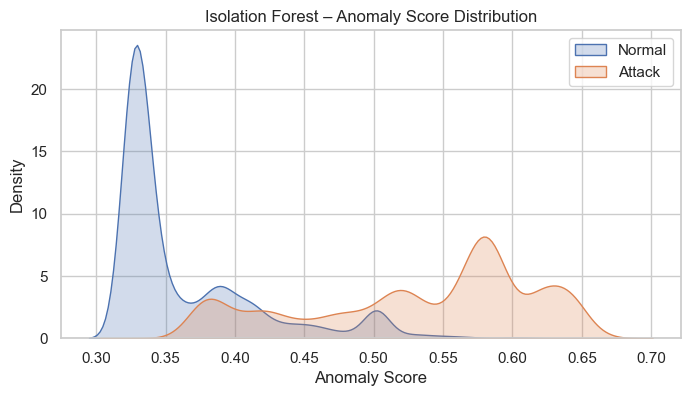

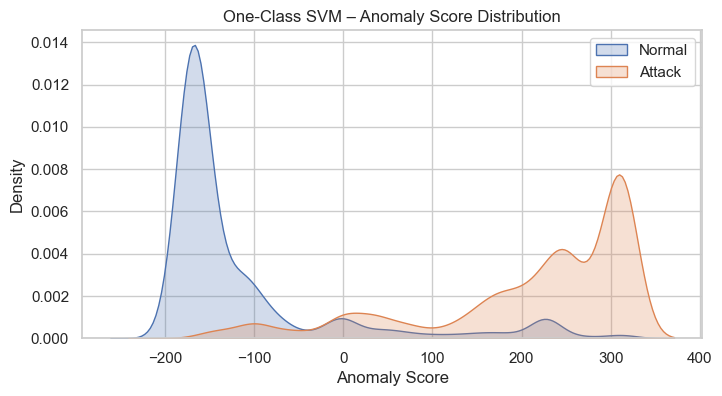

In [33]:
plt.figure(figsize=(8,4))
sns.kdeplot(iso_scores[y_test == 0], label="Normal", fill=True)
sns.kdeplot(iso_scores[y_test == 1], label="Attack", fill=True)
plt.title("Isolation Forest – Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(svm_scores[y_test == 0], label="Normal", fill=True)
sns.kdeplot(svm_scores[y_test == 1], label="Attack", fill=True)
plt.title("One-Class SVM – Anomaly Score Distribution")
plt.xlabel("Anomaly Score")
plt.legend()
plt.show()


#### 7. Summary

In this phase, unsupervised and semi-supervised machine learning models were applied for anomaly-based intrusion detection. Isolation Forest and One-Class SVM were trained exclusively on normal traffic samples to learn the underlying normal behavior. Both models demonstrated strong anomaly detection capability, achieving high ROC-AUC scores. Isolation Forest showed superior anomaly ranking performance, while One-Class SVM achieved slightly higher attack recall, highlighting the trade-off between detection sensitivity and anomaly scoring effectiveness.

